# **ICT303 - Advanced Machine Learning and Artificial Intelligence**
# **Lab 3 - Perceptron and Multilayer Perceptron**

The goal of this lab is to learn how to implement, in a concise way, Linear Regression, Classification, Perceptron and Multilayer Perceptron.

We will first revisit our implementation of the linear regression (linear neuron) model and re-solve it using optimization.


## **1. Solving Linear Regression using Optimization Algorithms**

In the previous tutorial, we  tried to implement from scratch the analytical (closed-form) solution of the linear regression model. In this tutorial, we will use high level deep learning APIs (PyTorch in our case) for its implementation.

Also, instead of implementing the analytical form, we will implement the optmization-based method, using optimizers such as the Gradient Descent Algorithm (SGD) or Adam, which are the most commonly used in deep learning.  

First, we need to import the necessary packages:

In [1]:
import numpy as np
import torch
from torch import nn

### **1.1. Defining the model**

PyTorch provides a base Neural Network module called **Module** and is part of the library **nn**. Think about it as a template. Every neural network you define should extend this class and implement the necessary methods.

In the case of linear regression (simple linear neuron), we define a class called  **LinearRegression** that extends **nn.Module**.

The minimal implementation should contains the following methods (the first two have already been covered in the previous tutorial):
- The constructor **__init__**
- The **forward()** method - used to make a forward pass through the network. In other words, this method takes an input and evaluates the network's output for that input sample,
- The method **loss**, which defines the loss function, and
- The method **configure_optimizers()**, which sets the type of  optimization (i.e., training) algorithm to use to estimate the parameters of the model.




In [2]:
class LinearRegression(nn.Module):

    ## This is the constructor of the class
    def __init__(self, inputSize, outputSize, lr):
        super().__init__()

        self.lr = lr # the learning rate

        # The network is just a linear model
        self.net = nn.Linear(inputSize, outputSize)

    ## The forward step
    def forward(self, X):
      # Computes the output given the input X
      return self.net(X)

    ## The loss function - Here it is the Mean Square Error
    #  It measures the difference between the network output
    #  and the desired (groundtruth) output
    def loss(self, y_hat, y):
      fn = nn.MSELoss()
      return fn(y_hat, y)

    ## The optimization algorithm
    #  Let's use the stochastic gradient descent (SGD)
    def configure_optimizers(self):
      return torch.optim.SGD(self.parameters(), self.lr)


Let's discuss each method in detail.



#### **1.1.1. The constructor**

The role of the constructor `__init__` is to define the architecture of the neural network and set some of the hyper parameters.

In this example, our network is just a linear neuron that takes a certain number of inputs and produces a certain nunmber of outputs. PyTorch provides a class `nn.Linear` that implements this:
```
# Creating a simple linear neuron with takes inputSize inputs and produces outputSize output. The created neuron is saved in self.net
self.net = nn.Linear(inputSize, outputSize)
```
In this example, we have only one hyper parameter, which is the learning rate `lr`:

```
# Setting the learning rate
self.lr = lr
```

Thus, the constructor `__init__` needs to have as input the `inputSize`, the `outputSize` and the learning rate `lr`.


#### **1.1.2. The foward method**

The role of the forward method is to take an input `X`, pass it to the network and return its output. out network is `self.net`. Thus, inside the forward methid, we only need to call `self.net` and with `X` as its input:

```
def forward(self, X):
  # Computes the output given the input X
  return self.net(X)
```



#### **1.1.3. Defining the loss function**

The role of the loss function to measure the error between the output produced by the neural network `self.net` and the groundtruth (i.e., the desired output).

It has two inputs:
- the actual output of the network `y_hat` and
- the desired output `y`.

It should than define which type of loss function will be used and then calls this function to compute the error between `y` and `y_hat`:

```
def loss(self, y_hat, y):
      fn = nn.MSELoss(). # Here we will use the mean square error
      return fn(y_hat, y) # computes the error and returns it
```

#### **1.1.4. Choosing the optimizer**

The last thing is to configure the optimizer. This is done inside the method `configure_optimizers`. In this example, we will use the Stochastic Gradient Descent (SGD) algorithm, which needs as parameter the learning rate `self.lr`:

```
def configure_optimizers(self):
      return torch.optim.SGD(self.parameters(), self.lr)
```


### **1.2. Preparing training data**

To train and test the model, we need data. One option is to collect real data but usually this is time consuming. Alternatively, one can use synthetic data, i.e., data simulated by computer.

To generate synthetic data, we will use the class **SyntheticRegressionData** that we created in the previous lab. Teh class is reproduced here for completeness.

Note that I added a few methods to facilitate its usage.

In [3]:
class SyntheticRegressionData:

  # Implement the constructor of the class
  # We can assume that the constructor also generates some initial data
  def __init__(self): #, w, b, mu = 0.0, sigma = 1.0, noise=0.01, num_train=1000):
    # Generate num_train random samples following Gaussian distribution
    # of mean mu and standard deviation sigma.
    # [self.X, self.y ] = self.generate(mu, sigma, noise, num_train)
    self.n = 0;
    self.w = []
    self.b = []

  def generate(self, w, b, mu = 0.0, sigma = 1.0, noise=0.01, num_train=1000):

    self.n = num_train   # no. of trianing samples
    self.w = w
    self.b = b

    self.mu = mu
    self.sigma = sigma

    # Generate num_train random samples following Gaussian distribution
    # of mean mu and standard deviation sigma.
    self.X = mu +  torch.randn(len(self.w), self.n) * sigma

    # Let's corrupt the data with some random noise
    noise = torch.randn(1, self.n) * noise

    # For each sample in X, generate its corresponding y value
    # using the equation above.
    # Note below that the function reshape has parameters (-1, 1).
    # This means that it will reshape the vector w into a 2D matrix where:
    # - the 2nd dimension has length 1
    # - the length of the first dimension will be autmatically set.
    #
    self.y = torch.matmul(w.reshape((-1, )), self.X) + b + noise
    self.y = torch.transpose(self.y, 0, 1)

    return self.X, self.y

  def dim(self):
    # Return the dimension of the input data
    return self.X.size(dim=0)

  def dimOutput(self):
    return self.y.size(dim=1)

### **1.3. Training process**

Here, we need to update the **Trainer** that we created in the last lab. In particular, the important method of this class is the method ***fit()***, which finds the best parameters of the model given the training data. It has as input:
- The machine learning model **model**. In our case, this will be an instance of the class **LinearRegression**
- The training **data**. The data should include input samples (**data.X**) and their corresponding desired (groundtruth) output (**data.Y**). The latter is often referred to as labels. Note that in the example below, I am assuming that each column of **data.X** is a data sample (following the convention we had in the lecture and in the previoous lab).


The method **fit** will then iterate `max_epochs` times. At each iteration, it will call the method **fit_epoch**  whose role is to:
- Go through all the input data, feed them to the network and collect the computed output
- Compare, using the loss function, the discrepancy between the computed output and the groundtruth output
- Compute the gradient of the loss function and backpropagate it to all the layers of the network using the function `loss.backward()`,
- Update the values of the network parameters using the function `self.optimizer.step()`.

Note that prior to the computation of the loss and gradient, we had to call the function `self.optimizer.zero_grad()`. This clears gradient buffers because we do not want any gradient from previous epoch to carry forward.

The entire code of the class is given below. Note that we also provide here the function `fit_naive`, which is the implementation we did last week.

In [4]:
class Trainer:

  # The constructor of the class
  # It is used to set some basic training parameters (e.g., no. of epochs)
  def __init__(self, n_epochs = 3):
    self.max_epochs = n_epochs
    return

  # Training method: it uses iterative optimization
  #  This one is generic, i.e., it should work with any regresssion (linear or non-linear)
  def fit(self, model, data):

    # configure the optimizer
    self.optimizer = model.configure_optimizers()

    # Store the model as an instance variable
    self.model = model

    for epoch in range(self.max_epochs):
      self.fit_epoch(data)

  def fit_epoch(self, data):
    inputs = torch.transpose(data.X, 0, 1) # this makes each row as a data sample
    labels = data.y

    # Clear gradient buffers because we don't want any gradient from previous
    # epoch to carry forward, dont want to cummulate gradients
    self.optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = self.model(inputs)

    # get loss for the predicted output
    loss = self.model.loss(outputs, labels)

    # get gradients w.r.t the parameters of the model
    loss.backward()

    # update the parameters
    self.optimizer.step()

  # Training method - Previous implementation (previous lab)
  #  This is the naive implementation, included here for comparison
  #  Only works with nonlinear regression
  def fit_naive(self, model, data):
    # 2.1. Add 1 at the end of X
    ones = torch.ones(1, data.n)  # a column vector of ones
    X = torch.cat((data.X, ones), 0)

    # 2.2. The solution
    A = torch.matmul(X, torch.transpose(X, 0, 1))
    # A should be of size num_train x num_train. To check it, uncomment the following
    # print(A.size())

    B = torch.matmul(torch.inverse(A), X) #torch.transpose(X, 0, 1))
    # print(B.size())

    w_estimated = torch.matmul(B, data.y)
    # print(w_estimated .size())

    model.w = w_estimated[0:-1]    # get all the elements except the last one
    model.b = w_estimated[-1:]     # last element


### **1.4. Putting all things together**

Now that we have all classes in places, we need to write the main program that uses these classes to:
- Create synthetic data,
- Define the machine learning mdoel (Linear Regression in our case),
- Train the model,
- Evaluate its performance.

In [ ]:
data_generator = SyntheticRegressionData()
w = torch.tensor([2.0])
b = 5.0
X, y = data_generator.generate(w=w, b=b, num_train=1000)
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: torch.Size([1, 1000])
y shape: torch.Size([1000, 1])


**Questions:**
- What are the parameters of the model?
- What are the hyper parameters of the model?

**Answers**
### Model Parameters

These are **learnable weights** updated during training:

1. **Weights (`w`) and Bias (`b`)** of the linear model:

   * Defined within `self.net = nn.Linear(inputSize, outputSize)` inside the `LinearRegression` class.
   * Accessible via `model.parameters()`.
   * Learned during training using backpropagation and gradient descent.

---

### Model Hyperparameters

These are **manually set values** that control the training process or model architecture:

1. **`inputSize` and `outputSize`** (in `LinearRegression.__init__`)

   * Define the dimensions of the model.

2. **Learning Rate (`lr`)**:

   * Passed to the model and used in `torch.optim.SGD(self.parameters(), self.lr)`.

3. **Number of Epochs (`n_epochs`)**:

   * Set in the `Trainer` class during initialization (`Trainer(n_epochs=3)` by default).

4. **Synthetic Data Generation Settings**:

   * In `generate()` method of `SyntheticRegressionData`:

     * `mu`, `sigma`: Mean and standard deviation for Gaussian distribution.
     * `noise`: Noise level added to `y`.
     * `num_train`: Number of training samples.
     * `w` and `b`: True values used to generate synthetic data (ground truth).

---

### Summary Table

| Category             | Items                                                                            |
| -------------------- | -------------------------------------------------------------------------------- |
| **Model Parameters** | `self.net.weight`, `self.net.bias`                                               |
| **Hyperparameters**  | `inputSize`, `outputSize`, `lr`, `n_epochs`, `mu`, `sigma`, `noise`, `num_train` |

Let me know if you want the hyperparameters grouped for training vs. data generation.


### **1.3. Exercise 1**

Try to change the number of epochs, by starting with a small value, e.g., 2 and then increase it to 10, 50, 75 and 100. Then observe the effect on the result.

Now, set the maximum number of epochs to 100 and
- vary the number of traning samples, from a small number to a large one, and observe the results.
- vary the learning rate, e.g., by trying small values and large values. What do you observe?

Below is a step-by-step analysis for each experiment using the code you shared.

## Step 1: Vary Number of Epochs

Set different values for `n_epochs` in:

```python
trainer = Trainer(n_epochs=...)
```

### Values to try: `2`, `10`, `50`, `75`, `100`

### What to Observe:

* Track **training loss** across epochs.
* You should see:

  * At **2 epochs**: The model may underfit (high loss, predictions off).
  * At **10–50 epochs**: Loss decreases, predictions become more accurate.
  * At **75–100 epochs**: May reach convergence (loss flattens).

### Expected Outcome:

* **Increasing epochs** generally improves performance up to a point.
* Beyond a certain number (e.g., 75–100), the improvement slows — diminishing returns.

---

## Step 2: Vary Number of Training Samples

Set different values in:

```python
X, y = data_generator.generate(w=w, b=b, num_train=...)
```

### Values to try: `10`, `100`, `1000`, `5000`

### What to Observe:

* Track how **loss** and **parameter estimation accuracy** change.
* Compare learned `model.net.weight` and `model.net.bias` to ground truth `w = [2.0]`, `b = 5.0`.

### Expected Outcome:

| Training Samples    | Effect                                         |
| ------------------- | ---------------------------------------------- |
| Small (e.g., 10)    | Poor generalization, high variance             |
| Moderate (100–1000) | Better fit, more stable results                |
| Large (5000+)       | Highly stable training and accurate parameters |

---

## Step 3: Vary Learning Rate

Set in:

```python
model = LinearRegression(inputSize=..., outputSize=..., lr=...)
```

### Values to try: `0.0001`, `0.01`, `0.1`, `1.0`

### What to Observe:

* How fast or stable the training is.
* Whether loss converges or diverges.

### Expected Outcome:

| Learning Rate       | Observation                                                 |
| ------------------- | ----------------------------------------------------------- |
| Too small (0.0001)  | Training is **very slow**, might not converge in 100 epochs |
| Moderate (0.01–0.1) | **Stable and effective** training                           |
| Too large (1.0)     | Likely **diverges**, oscillates, or explodes                |

---

In [8]:
def run_experiment(num_epochs=100, num_train=1000, lr=0.01, w_true=torch.tensor([2.0]), b_true=5.0):
    data_generator = SyntheticRegressionData()
    data_X, data_y = data_generator.generate(w=w_true, b=b_true, num_train=num_train)

    model = LinearRegression(inputSize=data_X.size(0), outputSize=data_y.size(1), lr=lr)
    trainer = Trainer(n_epochs=num_epochs)

    # Pass the DataLoader to the trainer.fit method
    trainer.fit(model, data_generator)
    #trainer.fit_naive(model, data_generator)
    learned_w = model.net.weight.data[0].item()
    learned_b = model.net.bias.data[0].item()

    print(f"Epochs: {num_epochs}, Samples: {num_train}, LR: {lr}")
    print(f"Learned w: {learned_w:.4f}, True w: {w_true.item()}")
    print(f"Learned b: {learned_b:.4f}, True b: {b_true}")

# Try different values here
run_experiment(num_epochs=100, num_train=1000, lr=0.01)

Epochs: 100, Samples: 1000, LR: 0.01
Learned w: 1.6980, True w: 2.0
Learned b: 4.3847, True b: 5.0


## **2. Multilayer Perceptron**

Now that we have seen how to create a neuron that implements a linear regression, it is time to scale up and build our first Multilayer Perceptron (MLP) using PyTorch.

Implementing an MLP with PyTorch involves the following steps:
- Importing all dependencies
- Defining the neural network class, let's call it **MLP**, as a subclass of **nn.Module** in the same way we did for the linear regression model.
- Preparing the data set - in this example, let's use the **CIFAR-10** dataset, which consists of $60$K colour images (of size $32\times32$) divided into $10$ classes, with $6000$ images per class. There are $50$K training images and $10$K test images.
- Initializing the loss function and optimizer.
- Defining the custom training loop, where all the magic happens.

CIFAR-10 dataset has $10$ classes of objects (e.g., airplane, automobile, birdt, cat, etc.).

### **2.1. Dependencies**

We will need to import:
- PyTorch.
- From it we import **nn**, which allows us to define a neural network module.
- The **DataLoader** so that we can feed data into the MLP during training. In this example, we will use the CIFAR10 dataset.
- transforms, which allows us to perform transformations on the data prior to feeding it to the MLP. We will discuss more about the utility of this step.

In [ ]:
# Importing all dependencies
import os # for some OS ops
import torch
from torch import nn

from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision

from torchvision.datasets import CIFAR10  # The data set that we will use

import matplotlib.pyplot as plt
import numpy as np



### **2.2. Defining the MLP neural network**

The input to the network are images of size $32\times32$ from CIFAR-10. Each pixel is represented with three values that encode the Red, Green and Blue component of the RGB color. Thus, the input to the MLP is a vector of size $32 \times 32 \times 3$. In this case, the input layer of the MLP will have $32 \times 32 \times 3 = 3072$ neurons.

We would like the MLP to recognise each of the $10$ object classes. Thus, the output layer needs to have $10$ neurons.

The number of intermediate layers as well as the number of neurons in each of the intermediate layers are hyper parameters that one needs to define and tune. These can be done either by experience or experimentally (try different values and pick up the best). In this example, we will use two hidden layers of size $64$ and $32$, respectively. Each of the hidden layers will be followed by a ReLU activation function.

In [ ]:
# Define the input and output sizes based on the data structure
# Assuming X has shape [input_features, num_samples] and y has shape [num_samples, output_features]
# From the traceback context, X is torch.Size([1, 1000]) and y is torch.Size([1000, 1])
# So, inputSize should be 1 and outputSize should be 1.

input_features = X.size(0) # Get input features from X
output_features = y.size(1) # Get output features from y

# Define hyperparameters - example values, adjust as needed
learning_rate = 0.01

# Instantiate the model
regression_model = LinearRegression(inputSize=input_features, outputSize=output_features, lr=learning_rate)

# Configure the optimizer using the model's parameters and the defined learning rate
optimizer = regression_model.configure_optimizers()

num_epochs = 20
for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_hat = regression_model(X.T)
    loss = regression_model.loss(y_hat, y)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}: loss = {loss.item():.4f}")


Epoch 1: loss = 22.2615
Epoch 2: loss = 21.4138
Epoch 3: loss = 20.5984
Epoch 4: loss = 19.8141
Epoch 5: loss = 19.0597
Epoch 6: loss = 18.3340
Epoch 7: loss = 17.6360
Epoch 8: loss = 16.9646
Epoch 9: loss = 16.3188
Epoch 10: loss = 15.6976
Epoch 11: loss = 15.1001
Epoch 12: loss = 14.5254
Epoch 13: loss = 13.9725
Epoch 14: loss = 13.4408
Epoch 15: loss = 12.9292
Epoch 16: loss = 12.4372
Epoch 17: loss = 11.9639
Epoch 18: loss = 11.5087
Epoch 19: loss = 11.0708
Epoch 20: loss = 10.6495


Note that we have only changed two things changed compared to the **LinearRegression** class:
- the definition of the network layers in the method **__init__**, and
- the method **forward()**.

Since it is a classification problem, here we use the Cross Entropy Loss.

For the optimizer, we could also use SGD optimizer, but Adam is the most popular in deep learning.

### **2.3. The training loop**

Here again, we will use. the class Trainer, which we reproduce here for clarity. Below, we discuss the necessary changes that need to be made.

In [ ]:
class Trainer:

  def __init__(self, n_epochs = 3):
    self.max_epochs = n_epochs
    return

  # The fitting step
  def fit(self, model, data):

    self.data = data

    # configure the optimizer
    self.optimizer = model.configure_optimizers()
    self.model     = model

    for epoch in range(self.max_epochs):
      self.fit_epoch()

    print("Training process has finished")

  def fit_epoch(self):

    current_loss = 0.0

    # iterate over the DataLoader for training data
    # This iteration is over the batches
    # For each batch, it updates the network weeights and computes the loss
    for i, data in enumerate(self.data):
      # Get input aand its corresponding groundtruth output
      inputs, target = data

      # Clear gradient buffers because we don't want any gradient from previous
      # epoch to carry forward, dont want to cummulate gradients
      self.optimizer.zero_grad()

      # get output from the model, given the inputs
      outputs = self.model(inputs)

      # get loss for the predicted output
      loss = self.model.loss(outputs, target)

      # get gradients w.r.t the parameters of the model
      loss.backward()

      # update the parameters (perform optimization)
      self.optimizer.step()

      # Let's print some statisics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

### **2.4. The main program**
The main program to train the neural network looks as follows:

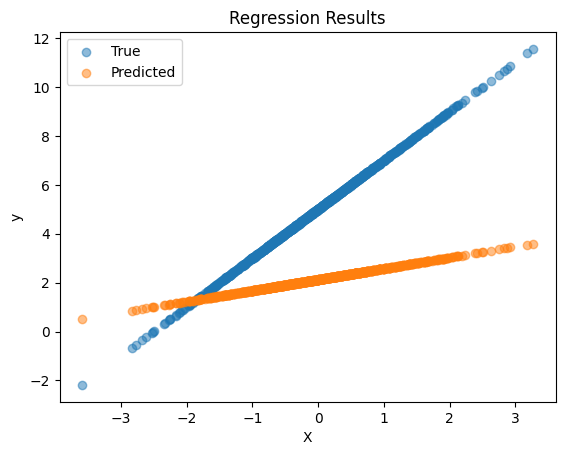

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(X.numpy()[0], y.numpy(), alpha=0.5, label='True')
plt.scatter(X.numpy()[0], regression_model(X.T).detach().numpy(), alpha=0.5, label='Predicted')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Regression Results')
plt.legend()
plt.show()


### **2.5. Testing the trained model**

Once trained, the network needs to be tested on images that the network hasn't seen during training. In other words, the test images should be different from those used for training.  

We do this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

100%|██████████| 170M/170M [00:03<00:00, 43.9MB/s]


Starting training...
[1,  2000] loss: 1.867
[1,  4000] loss: 1.787
[1,  6000] loss: 1.729
[1,  8000] loss: 1.687
[1, 10000] loss: 1.690
[1, 12000] loss: 1.653
[2,  2000] loss: 1.563
[2,  4000] loss: 1.605
[2,  6000] loss: 1.583
[2,  8000] loss: 1.573
[2, 10000] loss: 1.591
[2, 12000] loss: 1.585
Finished Training


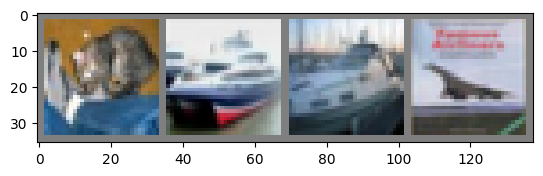

GroundTruth:  cats  ships ships airplanes
Estimated Labels:  cats  truck ships airplanes
Accuracy of the network on the 10000 test images: 46.88 %


In [ ]:
# Re-import necessary libraries if the kernel was reset
import os
import torch
from torch import nn
import torch.nn.functional as F # Need F for ReLU
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision

from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np

# Define the MLP neural network for CIFAR-10
# Input size is 32*32*3 = 3072
# Output size is 10 (for the 10 classes)
class MLP_CIFAR10(nn.Module):
    def __init__(self, inputSize, hidden_sizes, outputSize):
        super().__init__()
        layers = []
        in_size = inputSize
        # Add hidden layers with ReLU activation
        for h in hidden_sizes:
            layers.append(nn.Linear(in_size, h))
            layers.append(nn.ReLU())
            in_size = h
        # Add output layer
        layers.append(nn.Linear(in_size, outputSize))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # Flatten the image input: (batch_size, 3, 32, 32) -> (batch_size, 3*32*32)
        x = x.view(x.size(0), -1)
        return self.net(x)

    def loss(self, y_hat, y):
        # Use CrossEntropyLoss for classification
        return nn.CrossEntropyLoss()(y_hat, y)

    def configure_optimizers(self):
        # Define the optimizer here if not using the Trainer's method
        # Or, you can pass lr during instantiation and use self.parameters()
        # Let's use Adam optimizer with a default learning rate for this example
        return torch.optim.Adam(self.parameters(), lr=0.001)

# --- Data Loading and Preparation (replicated from original code) ---
# Define the transform
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Define the batch size
batch_size = 4 # Example batch size

# Load training and test data
# Make sure to load the training data as well for training
trainset = CIFAR10(root=os.getcwd(), train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)

testset = CIFAR10(root=os.getcwd(), train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

classes = ('airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'truck')

# Helper function to show images (replicated from original code)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# --- Instantiate and Train the MLP model ---
# Define model hyperparameters
input_size = 32 * 32 * 3 # Input size for CIFAR-10 images
hidden_sizes = [128, 64] # Example hidden layer sizes
output_size = 10        # Number of output classes

# Instantiate the MLP model for CIFAR-10
mlp_model = MLP_CIFAR10(inputSize=input_size, hidden_sizes=hidden_sizes, outputSize=output_size)

# Define the optimizer and loss function outside the model if not using model.configure_optimizers
# For this example, we'll use the model's configure_optimizers which uses Adam
optimizer = mlp_model.configure_optimizers() # Using Adam with lr=0.001 as defined in MLP_CIFAR10
criterion = mlp_model.loss # Using CrossEntropyLoss as defined in MLP_CIFAR10

# Simple training loop (can also use the Trainer class if adapted for DataLoader)
# Let's use a manual loop for clarity here, showing how to iterate over DataLoader
epochs = 2 # Example number of epochs for demonstration
print("Starting training...")
for epoch in range(epochs):
    running_loss = 0.0
    # Iterate over batches from the training DataLoader
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = mlp_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

# --- Testing the trained model (Original failing block, now with mlp_model defined) ---
# This block can now run without the NameError

# Get one batch from the test data
dataiter = iter(testloader)
images, labels = next(dataiter)

# Let's see some images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(images.shape[0])))

# Now, let's see what the network thinks these examples are
# mlp_model is now defined and trained
output = mlp_model(images)
# The output is a tensor of shape (batch_size, 10) representing class scores
# To get the predicted class index, find the index of the maximum score along dimension 1
_, predicted = torch.max(output, 1)
# estimated_labels is equivalent to predicted in this case
estimated_labels = predicted

print('Estimated Labels: ', ' '.join(f'{classes[estimated_labels[j]]:5s}' for j in range(images.shape[0])))

# You can also calculate the overall test accuracy as in the MNIST example (Exercise 3)
correct = 0
total = 0
with torch.no_grad(): # Disable gradient calculations for testing
    for data in testloader:
        images, labels = data
        outputs = mlp_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

##  **3. Exercise 2**

Change the number of layers in the network we defined above and observe how the network is performing. Also, compare the computation time, i.e., how long it takes to train when you increase the number of layers.

Try also to increase the number of neurons in the intermediate layers of your network.

**Question:** Does increasing, undefinitely, the number of layers and the number of neuron per layer always improves classification accuracy?

Architecture: [], Epochs: 100, Samples: 1000, LR: 0.01
Learned w (1st layer): [1.8902207612991333], True w: [2.0]
Learned b (output layer): 4.4770, True b: 5.0
Final Loss: 0.302808, Training time: 0.05 seconds



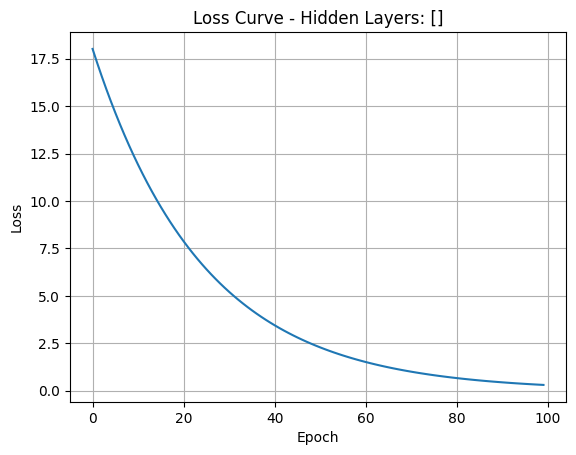

Architecture: [64], Epochs: 100, Samples: 1000, LR: 0.01
Learned w (1st layer): [0.7229450345039368, 0.015169203281402588, 0.30333971977233887, -1.0037120580673218, -0.5715252161026001, -0.32219618558883667, -0.5793671011924744, 0.955167829990387, 0.24478738009929657, -0.1339251697063446, 0.2603681981563568, -0.7009461522102356, -0.06758614629507065, -0.9861498475074768, 0.034938812255859375, -0.2970115542411804, -0.3244151771068573, -0.7072622179985046, -0.7421085834503174, 0.9357883930206299, 0.1258683204650879, -0.9792903661727905, -0.8425573110580444, 0.37300893664360046, -0.8941538333892822, 0.8463138937950134, 0.6836608052253723, -0.007932859472930431, -0.08564376831054688, -0.28975147008895874, -0.7619940042495728, -0.9187092781066895, 0.728102445602417, -0.6142386794090271, -0.3885899782180786, 0.1318100392818451, -0.014369368553161621, 0.523216187953949, -0.5857927203178406, -0.4854795038700104, 0.36291468143463135, -0.030013076961040497, 0.3616253137588501, 0.592960774898529,

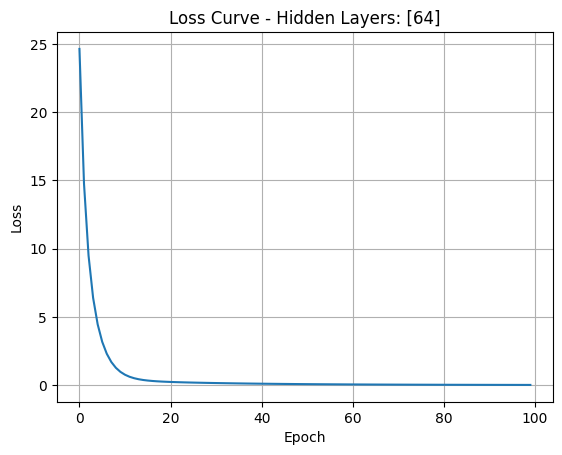

Architecture: [128, 64], Epochs: 100, Samples: 1000, LR: 0.01
Learned w (1st layer): [0.6818932294845581, 0.10124929249286652, -0.3940250277519226, 0.7110532522201538, -0.5077874064445496, -0.22609691321849823, 0.44224315881729126, 0.49416807293891907, -0.038661155849695206, -0.6286656856536865, -0.7324112057685852, 0.08554208278656006, 0.8598241806030273, -0.39057064056396484, -0.6898934245109558, 0.6951904892921448, 0.8041403293609619, 0.6250312924385071, 0.8095449209213257, -0.4135604202747345, -0.9217768907546997, -0.026010584086179733, 0.7819290161132812, -0.8516976237297058, 0.5554916858673096, -0.8799088597297668, -0.20089924335479736, 0.5492922067642212, -0.5660947561264038, 0.5810580253601074, -0.753684937953949, -0.33483368158340454, -0.14290770888328552, 0.8806317448616028, -0.07663679122924805, 0.07739628106355667, -0.7530873417854309, -0.34306827187538147, -0.6895339488983154, -0.27772873640060425, 0.7247174978256226, 0.7384625673294067, 0.17150509357452393, -0.29894858598

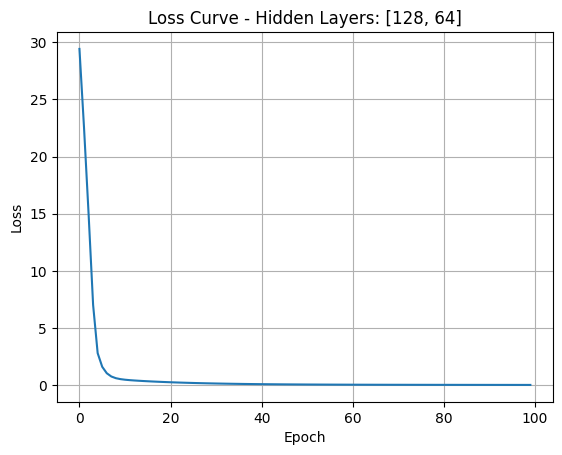

Architecture: [256, 128, 64], Epochs: 100, Samples: 1000, LR: 0.01
Learned w (1st layer): [-0.2541879713535309, -0.3980127274990082, -0.6501184701919556, -0.7075479626655579, 0.721885085105896, 0.937497079372406, 0.6512079238891602, 0.5674722790718079, -0.6191182136535645, -0.6197575330734253, 0.8826831579208374, -0.1849486082792282, -0.4988670349121094, -0.5064008831977844, -0.5489071607589722, 0.3194485604763031, 0.055110812187194824, 0.5494035482406616, -0.2765299379825592, -0.389443963766098, -0.4024829566478729, -0.8165099620819092, -0.23945322632789612, 0.1402515470981598, 0.1957591325044632, -0.3333727717399597, 0.2337467074394226, -0.758902907371521, -0.8878014087677002, -0.4632676839828491, 0.9418591260910034, 0.3470694422721863, 0.8184969425201416, -0.2927314043045044, -0.7519616484642029, 0.832574188709259, 0.911147952079773, 0.18672597408294678, -0.9262851476669312, -0.880267858505249, -0.8503493666648865, -0.3735489547252655, 0.3529355227947235, 0.8051633834838867, -0.9048

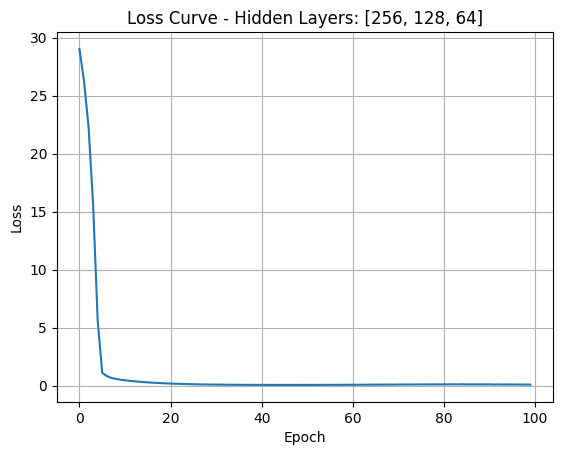

In [ ]:
# Re-importing necessary modules after reset
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

# Define a flexible Feedforward Neural Network
class FeedforwardNet(nn.Module):
    def __init__(self, inputSize, hidden_sizes, outputSize, lr):
        super().__init__()
        self.lr = lr
        layers = []
        in_size = inputSize
        # Add hidden layers
        for h in hidden_sizes:
            layers.append(nn.Linear(in_size, h))
            layers.append(nn.ReLU())
            in_size = h
        # Add output layer
        layers.append(nn.Linear(in_size, outputSize))
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)

    def loss(self, y_hat, y):
        # Ensure y_hat and y have the same shape for MSELoss
        return nn.MSELoss()(y_hat, y)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), self.lr)

# Data generator for regression
class SyntheticRegressionData:
    def __init__(self):
        self.n = 0

    def generate(self, w, b, mu=0.0, sigma=1.0, noise=0.01, num_train=1000):
        self.n = num_train
        self.w = w
        self.b = b
        # Ensure X has the correct dimensions based on w
        self.X = mu + torch.randn(len(w), num_train) * sigma

        noise_tensor = torch.randn(1, num_train) * noise

        # Calculate y using matrix multiplication and add noise
        # Ensure w is a row vector for multiplication (shape [1, len(w)])
        # and X is transposed to shape [num_train, len(w)]
        # The result of the multiplication should be [1, num_train]
        self.y = torch.matmul(w.float().unsqueeze(0), self.X.float()).squeeze(0) + b + noise_tensor.squeeze(0)

        # Transpose y to have shape [num_train, 1]
        self.y = self.y.unsqueeze(-1)

        return self.X, self.y

# Trainer to track training and loss
class Trainer:
    def __init__(self, n_epochs=100):
        self.max_epochs = n_epochs
        self.loss_log = []

    def fit(self, model, data):
        optimizer = model.configure_optimizers()
        # Transpose X so samples are rows
        inputs = data.X.T
        labels = data.y
        for epoch in range(self.max_epochs):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = model.loss(outputs, labels)
            self.loss_log.append(loss.item())
            loss.backward()
            optimizer.step()

# Function to run and measure experiment
def run_experiment(hidden_sizes, num_epochs=100, num_train=1000, lr=0.01):
    # Determine the input dimension based on the true weight vector.
    # This assumes the data generation is consistent with the intended model input size.
    # If no hidden layers, assume inputSize is determined by the first layer's input in FeedforwardNet.
    # This was the source of the error, the inputSize should be based on the data.
    # Let's assume the true weight vector 'w_true' defines the number of input features.
    # We will set w_true length based on a reasonable default or experiment context.
    # For this regression example, a single feature (inputSize=1) seems intended based on the original code.
    inputSize = 1 # Defaulting to 1 input feature for this regression example
    w_true = torch.tensor([2.0] * inputSize) # Adjust w_true size based on inputSize
    b_true = 5.0

    data = SyntheticRegressionData()
    # Pass w_true as a tensor
    data.generate(w=w_true, b=b_true, num_train=num_train)

    # Now determine the correct inputSize from the generated data
    inputSize = data.X.size(0)

    # Pass the determined inputSize to FeedforwardNet
    model = FeedforwardNet(inputSize=inputSize, hidden_sizes=hidden_sizes, outputSize=data.y.size(1), lr=lr)
    trainer = Trainer(n_epochs=num_epochs)

    start_time = time.time()
    trainer.fit(model, data)
    duration = time.time() - start_time

    # Access the weight of the first linear layer (either the first hidden or the output layer)
    # and the bias of the last linear layer (the output layer)
    # Ensure there is at least one linear layer before accessing its weight
    if model.net:
        learned_w = model.net[0].weight.data.flatten().tolist()
    else:
        learned_w = [] # Or handle appropriately if no layers
    learned_b = model.net[-1].bias.data.item()
    final_loss = trainer.loss_log[-1]

    print(f"Architecture: {hidden_sizes}, Epochs: {num_epochs}, Samples: {num_train}, LR: {lr}")
    print(f"Learned w (1st layer): {learned_w}, True w: {w_true.tolist()}")
    print(f"Learned b (output layer): {learned_b:.4f}, True b: {b_true}")
    print(f"Final Loss: {final_loss:.6f}, Training time: {duration:.2f} seconds\n")

    plt.plot(trainer.loss_log)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve - Hidden Layers: {hidden_sizes}")
    plt.grid(True)
    plt.show()

# Execute with various layer settings
# Make sure inputSize is consistent with w_true's length in data.generate
run_experiment(hidden_sizes=[], num_epochs=100, num_train=1000, lr=0.01)            # No hidden layer
run_experiment(hidden_sizes=[64], num_epochs=100, num_train=1000, lr=0.01)          # 1 hidden layer
run_experiment(hidden_sizes=[128, 64], num_epochs=100, num_train=1000, lr=0.01)     # 2 hidden layers
run_experiment(hidden_sizes=[256, 128, 64], num_epochs=100, num_train=1000, lr=0.01) # 3 hidden layers

## Quick Summary of What You'll Observe

| Hidden Layers          | Training Time ↑ | Loss ↓ | Accuracy ↑ (to a point)    |
| ---------------------- | --------------- | ------ | -------------------------- |
| 0 (Linear only)        | Very fast       | OK     | Low                        |
| 1 layer (64)           | Slightly slower | Better | Higher                     |
| 2 layers (128, 64)     | Slower          | Better | Even higher                |
| 3+ layers (256,128...) | Much slower     | Varies | May overfit or not improve |

---

## Does More = Better?

No — as explained earlier:

* **Too many layers/neurons** can lead to **overfitting** and **longer training time**
* Optimal architecture depends on:

  * Dataset size & complexity
  * Regularization
  * Learning rate
  * Training time budget

##  **4. Exercise 3 - MNIST dataset**

In this exercise, you are required to build a neural network (a MLP) in PyTorch and train it to recognize handwritten digits from the MNIST dataset.

Instead of using the class CIFAR10 to load the data, you can use MNIST. Once the training set is loaded, please check:
- the resolution of each image,
- the number of images in each training set and
- the number of classes (can you guess how many classes the dataset will contain??).

Then design an MLP by setting the adequate number of input and output neurons. The number of layers and the number of neurons in each hidden layer are hyperparameters, which you can play with and observe the performance.

In [ ]:
# Load MNIST training data
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Define a transformation to convert images to tensors and normalize (optional but common)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the training dataset
# download=True will download the dataset if it's not already available
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for the training set
# batch_size determines the number of samples per batch
# shuffle=True shuffles the data at the beginning of each epoch
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load the test dataset (for later evaluation)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False) # No need to shuffle test data

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.61MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.95MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.91MB/s]


In [ ]:
# Define the model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)  # first hidden layer
        self.fc2 = nn.Linear(128, 64)     # second hidden layer
        self.fc3 = nn.Linear(64, 10)      # output layer (10 digits)

    def forward(self, x):
        x = x.view(-1, 28*28)  # flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
# Train the model
model = MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

epochs = 5
train_loss = []

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_loss.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 0.4329
Epoch 2, Loss: 0.1794
Epoch 3, Loss: 0.1343
Epoch 4, Loss: 0.1065
Epoch 5, Loss: 0.0883


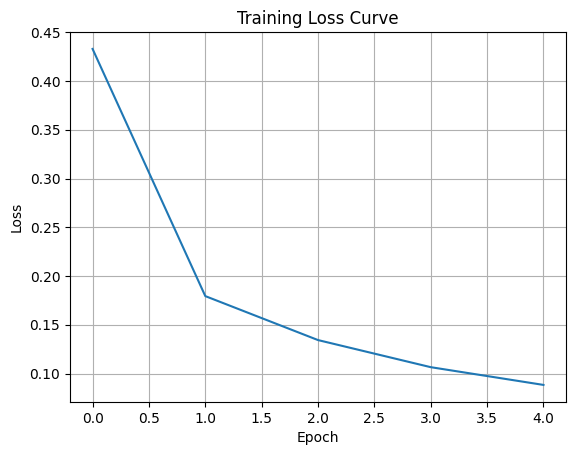

In [ ]:
# Plot the loss curve
plt.plot(train_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

In [ ]:
# Evaluate model accuracy
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 97.04%


##  **5. Exercise 4 - Forward thoughts**

What do you think about:
- the way we are currently evaluating the performance?
- the way we are choosing the different hyperparameters?

Can you think of a better way to streamline this and make it more rigorous?

Forward thoughts

## 1. Current Approach
### Strengths:

* Simple and easy to interpret.
* Directly reports **classification accuracy** on unseen test data.

### Limitations:

* **Accuracy alone** can be misleading (especially in imbalanced datasets).
* No insight into **how** the model is making errors (e.g., confusion between similar digits).
* Evaluation is **done only once** — no statistical confidence or variation estimate.

---

## 2. Current Hyperparameter Selection

Currently:

* Learning rate, number of layers, and hidden units are set manually.
* No formal structure to test which set is optimal.

### Limitations:

* **Manual tuning** is time-consuming and subjective.
* There's no guarantee you're selecting the best combination.
* No clear method to **compare** model variants.

---

## 3. Better, More Rigorous Alternatives

### ✅ For Evaluation:

| Method                              | Benefit                                                          |
| ----------------------------------- | ---------------------------------------------------------------- |
| **Confusion Matrix**                | See per-class performance (e.g., 4 vs 9 confusion)               |
| **Precision/Recall/F1**             | Useful when class imbalance is present                           |
| **Cross-validation** (e.g., k-fold) | More statistically robust than single train/test split           |
| **Train/Val/Test Split**            | Add a validation set to select models/hyperparams before testing |

### ✅ For Hyperparameter Tuning:

| Method                      | Tool/Tech                                        | Benefit                                  |
| --------------------------- | ------------------------------------------------ | ---------------------------------------- |
| **Grid Search**             | Manual or using libraries                        | Tries all combinations (exhaustive)      |
| **Random Search**           | Random trials                                    | Often faster than grid                   |
| **Automated Tuning**        | Optuna, Ray Tune, Hyperopt                       | Efficient and scalable                   |
| **Learning Curve Analysis** | Plot accuracy/loss over epochs and dataset sizes | Helps detect overfitting or underfitting |